In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# conda install pytorch torchvision -c pytorch 
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut


In [167]:
# data/output_df의 파일들과 data/weather의 파일들을 읽어온다.
seoul_output_df = pd.read_csv('data/output_df/seoul_spring_df.csv')
seoul_spring_df = pd.read_csv('data/weather/seoul_spring.csv')

# 위에 파일들을 합친다.
seoul_df = pd.merge(seoul_output_df, seoul_spring_df, on='일시', how='left')

# 출력
seoul_df



,일시,일반봄배추:면적 (ha),생산량 (톤),평균기온(°C),최고기온(°C),최저기온(°C),월합강수량(00~24h만)(mm),합계 일사량(MJ/m2)
0,2000,72,2660,6.3,18.9,-4.8,3.1,389.50
1,2000,72,2660,11.9,23.5,1.8,30.7,440.90
2,2000,72,2660,17.5,30.5,7.9,75.2,443.69
3,2001,8,353,5.0,21.0,-6.1,18.1,396.53
4,2001,8,353,13.6,28.2,2.1,12.3,492.04
...,...,...,...,...,...,...,...,...
61,2020,0,1,11.1,23.8,1.9,16.9,637.52
62,2020,0,1,18.0,30.0,9.2,112.4,564.83
63,2021,5,228,9.0,22.9,-1.2,110.9,476.94
64,2021,5,228,14.2,28.2,3.1,124.1,558.28


In [168]:
# 입력데이터 정규화
scaler = MinMaxScaler()
seoul_df.iloc[:, 1:] = scaler.fit_transform(seoul_df.iloc[:, 1:])
seoul_df





,일시,일반봄배추:면적 (ha),생산량 (톤),평균기온(°C),최고기온(°C),최저기온(°C),월합강수량(00~24h만)(mm),합계 일사량(MJ/m2)
0,2000,0.818182,1.000000,0.167702,0.244792,0.142857,0.000000,0.178047
1,2000,0.818182,1.000000,0.515528,0.484375,0.479592,0.126085,0.313506
2,2000,0.818182,1.000000,0.863354,0.848958,0.790816,0.329374,0.320859
3,2001,0.090909,0.132707,0.086957,0.354167,0.076531,0.068524,0.196574
4,2001,0.090909,0.132707,0.621118,0.729167,0.494898,0.042028,0.448280
...,...,...,...,...,...,...,...,...
61,2020,0.000000,0.000376,0.465839,0.500000,0.484694,0.063042,0.831677
62,2020,0.000000,0.000376,0.894410,0.822917,0.857143,0.499315,0.640111
63,2021,0.056818,0.085714,0.335404,0.453125,0.326531,0.492462,0.408486
64,2021,0.056818,0.085714,0.658385,0.729167,0.545918,0.552764,0.622849


In [169]:
# LSTM 다음연도 생산량 예측
# LSTM 모델을 만들기 위해 데이터를 3차원으로 변환한다.
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix, :-1], sequence[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# 데이터를 3차원으로 변환한다.
n_steps = 3
X, y = split_sequence(seoul_df.values, n_steps)

# 데이터를 학습데이터와 테스트데이터로 나눈다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 데이터를 텐서데이터셋으로 변환한다.
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

# 데이터로더를 만든다.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# LSTM 모델을 만든다.
class LSTM(torch.nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = torch.nn.LSTM(input_size=8, hidden_size=64, num_layers=2, batch_first=True)
        self.linear = torch.nn.Linear(64, 1)
        
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.linear(x[:, -1, :])
        return x

# 모델을 만든다.
model = LSTM()

# 손실함수와 옵티마이저를 만든다.
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 모델을 학습시킨다.
for epoch in range(1000):
    model.train()
    for x_train, y_train in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train.unsqueeze(1))
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 100 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

        

RuntimeError: input.size(-1) must be equal to input_size. Expected 8, got 7

In [ ]:
# 모델을 평가한다.
model.eval()

LSTM(
  (lstm): LSTM(8, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

Test Loss: 0.032812


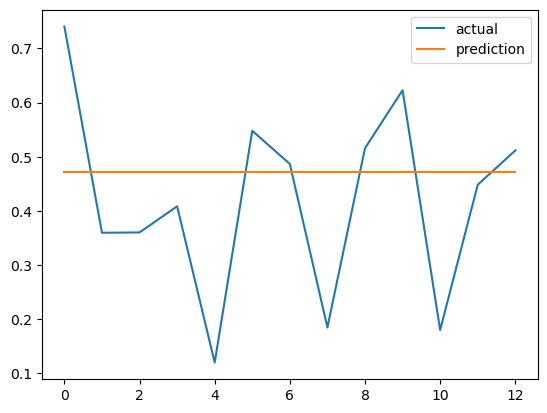

MSE: 0.032812
MAE: 0.141276
R2: -0.084791


In [ ]:

# 테스트 데이터로 예측한다.
with torch.no_grad():
    for x_test, y_test in test_loader:
        y_pred = model(x_test)
        loss = criterion(y_pred, y_test.unsqueeze(1))
        print('Test Loss: {:.6f}'.format(loss))

        y_pred = y_pred.detach().numpy()
        y_test = y_test.detach().numpy()
        plt.plot(y_test, label='actual')
        plt.plot(y_pred, label='prediction')
        plt.legend()
        plt.show()

        print('MSE: {:.6f}'.format(mean_squared_error(y_test, y_pred)))
        print('MAE: {:.6f}'.format(mean_absolute_error(y_test, y_pred)))
        print('R2: {:.6f}'.format(r2_score(y_test, y_pred)))

        break

# 모델을 저장한다.
torch.save(model.state_dict(), 'model/lstm.pth')


In [ ]:
#  다음 연도 생산량 예측

# 입력데이터를 만든다.
input_data = seoul_df.iloc[-3:, 1:].values

# 입력데이터를 3차원으로 변환한다.
input_data = input_data.reshape(1, n_steps, 8)

# 모델을 불러온다.
model = LSTM()
model.load_state_dict(torch.load('model/lstm.pth'))

# 입력데이터로 예측한다.
with torch.no_grad():
    y_pred = model(torch.from_numpy(input_data).float())
    y_pred = y_pred.detach().numpy()
    print('예측값:', y_pred[0][0])

# 2022년 생산량 예측
print('2022년 생산량 예측:', y_pred[0][0] + seoul_df.iloc[-1, 1])

# 역정규화한다.












예측값: 0.13383915
2022년 생산량 예측: 0.19065732712095435
